In [15]:
!git clone https://github.com/olivesgatech/Semi-supervised-Learning-for-Acoustic-Impedance-Inversion

Cloning into 'Semi-supervised-Learning-for-Acoustic-Impedance-Inversion'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 118 (delta 26), reused 41 (delta 16), pack-reused 57
Receiving objects: 100% (118/118), 97.38 MiB | 31.49 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [16]:
%cd Semi-supervised-Learning-for-Acoustic-Impedance-Inversion/

/content/Semi-supervised-Learning-for-Acoustic-Impedance-Inversion/Semi-supervised-Learning-for-Acoustic-Impedance-Inversion


Step by step tutorial

load data

In [17]:
import numpy as np
import matplotlib.pyplot as plt

import torch

In [18]:
data_dic = np.load("data/data.npy",allow_pickle=True).item()

seismic_data = data_dic["seismic"]
acoustic_impedance_data = data_dic["acoustic_impedance"]

pre-process

In [19]:
#%% Normalization
class Normalization:
    def __init__(self, mean_val=None,std_val=None):
        self.mean_val = mean_val
        self.std_val = std_val

    def normalize(self, x):
        return (x-self.mean_val)/self.std_val

    def unnormalize(self, x):
        return x*self.std_val + self.mean_val

In [20]:
seismic_mean = torch.tensor(np.mean(seismic_data,keepdims=True)).float()
seismic_std = torch.tensor(np.std(seismic_data,keepdims=True)).float()

acoustic_mean= torch.tensor(np.mean(acoustic_impedance_data, keepdims=True)).float()
acoustic_std = torch.tensor(np.std(acoustic_impedance_data,keepdims=True)).float()


seismic_data = torch.tensor(seismic_data).float()
acoustic_impedance_data = torch.tensor(acoustic_impedance_data).float()


seismic_normalization = Normalization(mean_val=seismic_mean,
                                      std_val=seismic_std)

acoustic_normalization = Normalization(mean_val=acoustic_mean,
                                      std_val=acoustic_std)


seismic_data = seismic_normalization.normalize(seismic_data)
acoustic_impedance_data = acoustic_normalization.normalize(acoustic_impedance_data)

Set up data loader

In [21]:
from torch.utils import data

num_train_wells = 20
batch_size = 64
num_samples = seismic_data.shape[0]
indecies = np.arange(0,num_samples)
train_indecies = indecies[(np.linspace(0,len(indecies)-1, num_train_wells)).astype(int)]

train_data = data.Subset(data.TensorDataset(seismic_data,acoustic_impedance_data), train_indecies)
train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=False)

unlabeled_loader = data.DataLoader(data.TensorDataset(seismic_data), batch_size=batch_size, shuffle=True)


test_loader = data.DataLoader(data.TensorDataset(seismic_data,acoustic_impedance_data), batch_size=batch_size, shuffle=False, drop_last=False)

get model

In [22]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from torch.nn.functional import conv1d



class inverse_model(nn.Module):
    def __init__(self,resolution_ratio=4,nonlinearity="tanh"):
        super(inverse_model, self).__init__()
        self.resolution_ratio = resolution_ratio
        self.activation =  nn.ReLU() if nonlinearity=="relu" else nn.Tanh()

        self.cnn1 = nn.Sequential(nn.Conv1d(in_channels=1,
                                           out_channels=8,
                                           kernel_size=5,
                                           padding=2,
                                           dilation=1),
                                  nn.GroupNorm(num_groups=1,
                                               num_channels=8))

        self.cnn2 = nn.Sequential(nn.Conv1d(in_channels=1,
                                           out_channels=8,
                                           kernel_size=5,
                                           padding=6,
                                           dilation=3),
                                  nn.GroupNorm(num_groups=1,
                                               num_channels=8))

        self.cnn3 = nn.Sequential(nn.Conv1d(in_channels=1,
                                           out_channels=8,
                                           kernel_size=5,
                                           padding=12,
                                           dilation=6),
                                  nn.GroupNorm(num_groups=1,
                                               num_channels=8))

        self.cnn = nn.Sequential(self.activation,
                                 nn.Conv1d(in_channels=24,
                                           out_channels=16,
                                           kernel_size=3,
                                           padding=1),
                                 nn.GroupNorm(num_groups=1,
                                              num_channels=16),
                                 self.activation,

                                 nn.Conv1d(in_channels=16,
                                           out_channels=16,
                                           kernel_size=3,
                                           padding=1),
                                 nn.GroupNorm(num_groups=1,
                                              num_channels=16),
                                 self.activation,

                                 nn.Conv1d(in_channels=16,
                                           out_channels=16,
                                           kernel_size=1),
                                 nn.GroupNorm(num_groups=1,
                                              num_channels=16),
                                 self.activation)

        self.gru = nn.GRU(input_size=1,
                          hidden_size=8,
                          num_layers=3,
                          batch_first=True,
                          bidirectional=True)

        self.up = nn.Sequential(nn.ConvTranspose1d(in_channels=16,
                                                   out_channels=8,
                                                   stride=2,
                                                   kernel_size=4,
                                                   padding=1),
                                nn.GroupNorm(num_groups=1,
                                             num_channels=8),
                                self.activation,

                                nn.ConvTranspose1d(in_channels=8,
                                                   out_channels=8,
                                                   stride=2,
                                                   kernel_size=4,
                                                   padding=1),
                                nn.GroupNorm(num_groups=1,
                                             num_channels=8),
                                self.activation)

        self.gru_out = nn.GRU(input_size=8,
                              hidden_size=8,
                              num_layers=1,
                              batch_first=True,
                              bidirectional=True)
        self.out = nn.Linear(in_features=16, out_features=1)


        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
                nn.init.xavier_uniform_(m.weight.data)
                m.bias.data.zero_()
            elif isinstance(m, nn.GroupNorm):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        cnn_out1 = self.cnn1(x)
        cnn_out2 = self.cnn2(x)
        cnn_out3 = self.cnn3(x)
        cnn_out = self.cnn(torch.cat((cnn_out1,cnn_out2,cnn_out3),dim=1))

        tmp_x = x.transpose(-1, -2)
        rnn_out, _ = self.gru(tmp_x)
        rnn_out = rnn_out.transpose(-1, -2)

        x = rnn_out + cnn_out
        x = self.up(x)

        tmp_x = x.transpose(-1, -2)
        x, _ = self.gru_out(tmp_x)

        x = self.out(x)
        x = x.transpose(-1,-2)
        return x



class forward_model(nn.Module):
    def __init__(self,resolution_ratio=4,nonlinearity="tanh"):
        super(forward_model, self).__init__()
        self.resolution_ratio = resolution_ratio
        self.activation =  nn.ReLU() if nonlinearity=="relu" else nn.Tanh()
        self.cnn = nn.Sequential(nn.Conv1d(in_channels=1, out_channels=4, kernel_size=9, padding=4),
                                 self.activation,
                                 nn.Conv1d(in_channels=4, out_channels=4,kernel_size=7, padding=3),
                                 self.activation,
                                 nn.Conv1d(in_channels=4, out_channels=1,kernel_size=3, padding=1))


        self.wavelet = nn.Conv1d(in_channels=1,
                             out_channels=1,
                             stride=self.resolution_ratio,
                             kernel_size=50,
                             padding=int((50-self.resolution_ratio+2)/2))

    def forward(self, x):
        x = self.cnn(x)
        x = self.wavelet(x)
        return x

In [23]:
from torch import nn, optim

inverse_net = inverse_model()
forward_net = forward_model()
optimizer = optim.Adam(list(inverse_net.parameters())+list(forward_net.parameters()), amsgrad=True,lr=0.005)

In [24]:

inverse_net.train()
criterion = nn.MSELoss()

In [25]:
#%% Metrics
def metrics(y,x):
    #x: reference signal
    #y: estimated signal

    x = x.numpy()

    y = y.numpy()

    #corrlation
    x_mean = np.mean(x, axis=-1, keepdims=True)
    y_mean = np.mean(y, axis=-1, keepdims=True)
    x_std = np.std(x, axis=-1, keepdims=True)
    y_std = np.std(y, axis=-1, keepdims=True)
    corr = np.mean((x-x_mean)*(y-y_mean), axis=-1,keepdims=True)/(x_std*y_std)

    #coefficeint of determination (r2)
    S_tot = np.sum((x-x_mean)**2, axis=-1, keepdims=True)
    S_res = np.sum((x - y)**2, axis=-1, keepdims=True)

    r2 = (1-S_res/S_tot)

    return torch.tensor(corr), torch.tensor(r2)


In [26]:
from tqdm import tqdm

max_epoch = 100
alpha = 1
beta = 0.2


print("Training the model")
best_loss = np.inf
for epoch in tqdm(range(max_epoch)):
    train_loss = []
    train_property_corr = []
    train_property_r2 = []
    for x,y in train_loader:
        optimizer.zero_grad()
        y_pred = inverse_net(x)
        x_rec = forward_net(y)

        property_loss = criterion(y_pred,y)+criterion(x_rec, x)
        corr, r2 = metrics(y_pred.detach(),y.detach())
        train_property_corr.append(corr)
        train_property_r2.append(r2)

        if beta!=0:
            #loading unlabeled data
            try:
                x_u = next(unlabeled)[0]
            except:
                unlabeled = iter(unlabeled_loader)
                x_u = next(unlabeled)[0]

            y_u_pred = inverse_net(x_u)
            x_u_rec = forward_net(y_u_pred)

            seismic_loss = criterion(x_u_rec,x_u)
        else:
            seismic_loss=0
        loss = alpha*property_loss + beta*seismic_loss
        loss.backward()
        optimizer.step()

        train_loss.append(loss.detach().clone())

  0%|          | 0/100 [00:00<?, ?it/s]

Training the model


100%|██████████| 100/100 [04:11<00:00,  2.51s/it]



Testing the model

loss: 0.0000
Correlation: 0.9454
r2 Coeff.  : 0.8552


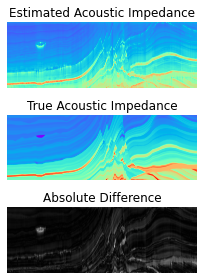

In [28]:
def display_results(loss, property_corr, property_r2, header):
    property_corr = torch.mean(torch.cat(property_corr), dim=0).squeeze()
    property_r2 = torch.mean(torch.cat(property_r2), dim=0).squeeze()
    loss = torch.mean(torch.tensor(loss))
    print("loss: {:.4f}\nCorrelation: {:0.4f}\nr2 Coeff.  : {:0.4f}".format(loss,property_corr,property_r2))



predicted_impedance = []
true_impedance = []
test_property_corr = []
test_property_r2 = []
inverse_net.eval()
print("\nTesting the model\n")

with torch.no_grad():
    test_loss = []
    for x,y in test_loader:
        y_pred = inverse_net(x)
        property_loss = criterion(y_pred,y)/np.prod(y.shape)
        corr, r2 = metrics(y_pred.detach(),y.detach())
        test_property_corr.append(corr)
        test_property_r2.append(r2)

        x_rec = forward_net(y_pred)
        seismic_loss = criterion(x_rec, x)/np.prod(x.shape)
        loss = alpha*property_loss + beta*seismic_loss
        test_loss.append(loss.item())

        true_impedance.append(y)
        predicted_impedance.append(y_pred)


    display_results(test_loss, test_property_corr, test_property_r2, header="Test")

    predicted_impedance = torch.cat(predicted_impedance, dim=0)
    true_impedance = torch.cat(true_impedance, dim=0)

    predicted_impedance = acoustic_normalization.unnormalize(predicted_impedance)
    true_impedance = acoustic_normalization.unnormalize(true_impedance)



    predicted_impedance = predicted_impedance.numpy()
    true_impedance = true_impedance.numpy()

    #diplaying estimated section

    plt.subplot(3,1,1)
    plt.imshow(predicted_impedance[:,0].T, cmap='rainbow',aspect=0.5, vmin=true_impedance.min(), vmax=true_impedance.max())
    plt.axis('off')
    plt.title("Estimated Acoustic Impedance")

    plt.subplot(3,1,2)
    plt.imshow(true_impedance[:,0].T, cmap='rainbow',aspect=0.5,vmin=true_impedance.min(), vmax=true_impedance.max())
    plt.title("True Acoustic Impedance")
    plt.axis('off')

    plt.subplot(3,1,3)
    plt.imshow(abs(true_impedance[:,0].T-predicted_impedance[:,0].T), cmap='gray',aspect=0.5)
    plt.title("Absolute Difference")
    plt.axis('off')

    plt.tight_layout()


    plt.show()